## Optimizer: Adam + lr scheduling

Inverse square root scheduling is important to the stability when training Transformer. It's later used on RNN as well.
Update the learning rate according to the following equation. Linearly increase the first stage, then decay proportionally to the inverse square root of timestep.

$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$

In [12]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from math import pow

In [3]:
def get_rate(d_model, step_num, warmup_step) -> float:
    return pow(d_model, -0.5) * min(pow(step_num, -0.5), step_num * pow(warmup_step, -1.5))

In [8]:
class NoamOpt:
    """ Optimizer wrapper that implements rate. """
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    @property
    def param_groups(self):
        return self.optimizer.param_groups

    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)

    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * get_rate(self.model_size, step, self.warmup)


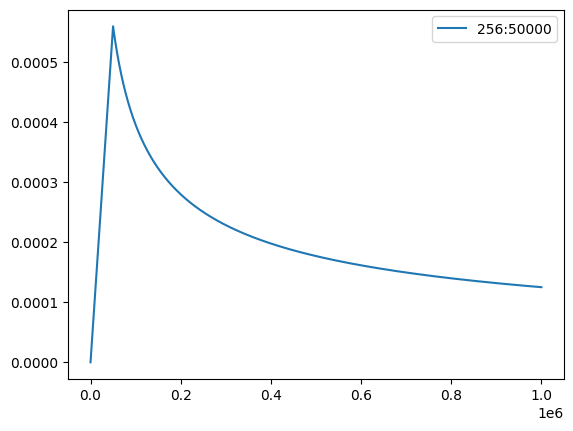

In [20]:
model = torch.nn.Linear(256, 256)
optimizer = NoamOpt(
    model_size=256,
    factor=2.0,
    warmup=50000,
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001)
)

plt.plot(np.arange(1, 1e6), [optimizer.rate(i) for i in range(1, int(1e6))])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])